# Описание проекта

**Цель:**  
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.  

**Условия:**
- Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
- На основе модели исследовать основные факторы ДТП. 

**Основные вопросы от заказчика:**
- Возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.  
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Загрузка данных

### Импортируем библиотеки

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,  OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from phik.report import plot_correlation_matrix
from sqlalchemy import create_engine


pd.set_option('display.max_columns', None)

###  Подключение к базе. Загрузка таблиц sql

In [2]:
db_config = {
'user': 'praktikum_student', 
'pwd': 'Sdf4$2;d-d30pp', 
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, 
'db': 'data-science-vehicle-db' 
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

## Первичиный анализ 

Посмотрим, какие таблицы присутвуют в нашей базе данных.

In [3]:
query = '''
SELECT relname
FROM pg_stat_user_tables 
'''
pd.read_sql_query(query, con=engine)

,relname
0,vehicles
1,collisions
2,case_ids
3,parties


In [4]:
query = '''
SELECT *
FROM vehicles
LIMIT 10
'''
pd.read_sql_query(query, con=engine)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [5]:
query = '''
SELECT *
FROM collisions
LIMIT 10
'''
pd.read_sql_query(query, con=engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [6]:
query = '''
SELECT *
FROM case_ids
LIMIT 10
'''
pd.read_sql_query(query, con=engine)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [7]:
query = '''
SELECT *
FROM parties
LIMIT 10
'''
pd.read_sql_query(query, con=engine)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


- В базе данных содержится 4 таблицы: `vehicles`, `collisions`, `case_ids`, `parties`. Их количество соответсвует условию задачи.
- Все таблицы имеют 1 общий ключ для связи - `case_id`
- Все таблицы имеют наборы данных.

## Статистический анализ

Выясним в какие месяцы происходит наибольшее количество аварий.\
Сначала посмотрим какое количество ДТП было зафиксировано по годам.

In [8]:
query_collisions = '''SELECT EXTRACT('year' FROM collision_date) year_of_collision,
                             COUNT(*)
                      FROM collisions
                      GROUP BY EXTRACT('year' FROM collision_date)
                   '''
print(pd.read_sql_query(query_collisions, con=engine))

   year_of_collision   count
0             2009.0  426228
1             2010.0  416490
2             2011.0  402428
3             2012.0  154547
4             2013.0     305
5             2020.0       2


Теперь посмотрим на количество ДТП внутри каждого года по месяцам. Данные за 2013 и 2020 год не будем рассматривать т.к. количество наблюдений резко падает. Причиной этому могут быть различные  факторы, но скорее всего, просто перестали записывать новые данные в таблицу.

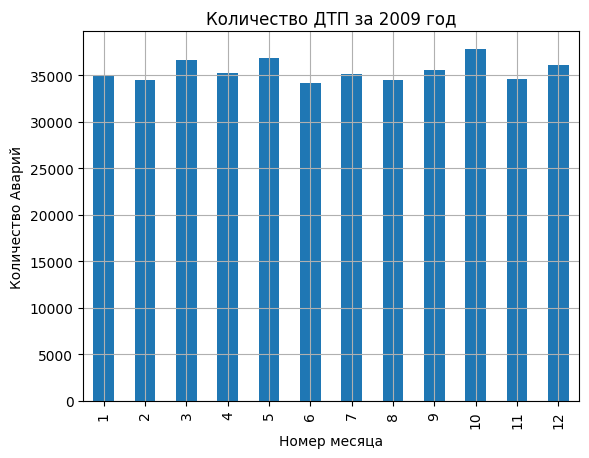

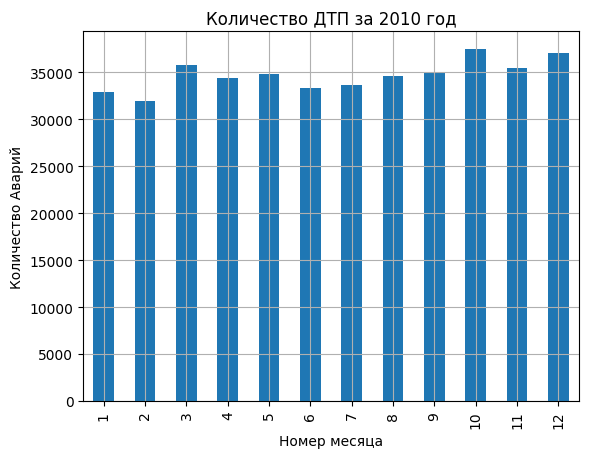

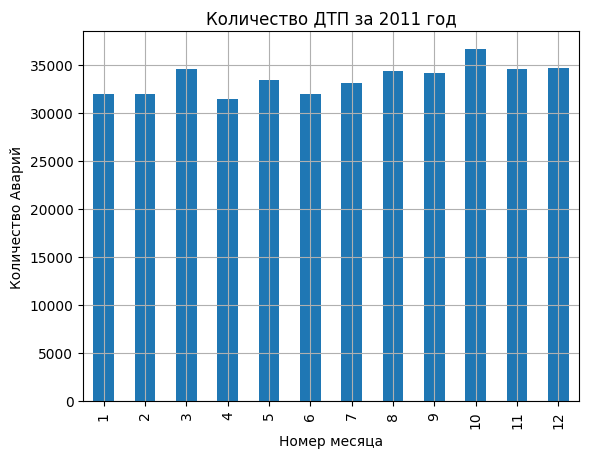

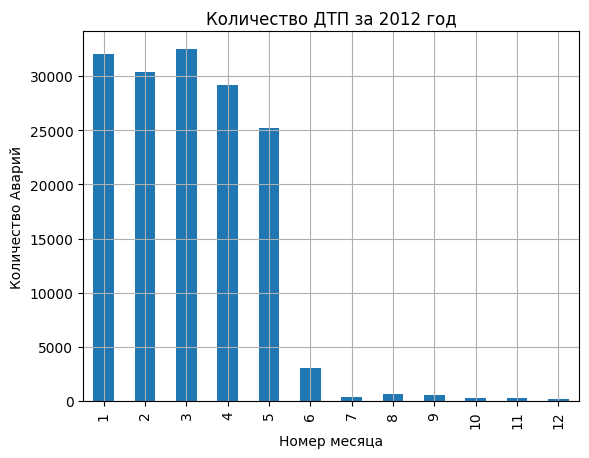

In [9]:
for year in [2009, 2010, 2011, 2012]:
    query_collisions = f'''SELECT EXTRACT('month' FROM collision_date)::int AS month_of_collision,
                             COUNT(*) AS num_collisions
                          FROM collisions
                          WHERE EXTRACT('year' FROM collision_date) = {year}
                          GROUP BY EXTRACT('month' FROM collision_date)
                       '''
    pd.read_sql_query(query_collisions, con=engine, index_col='month_of_collision').plot.bar(grid=True, legend=False)
    plt.title(f"Количество ДТП за {year} год")
    plt.xlabel("Номер месяца")
    plt.ylabel("Количество Аварий")
    plt.show();

В данных за 2012 год зафиксировано аномально низкое количество происшествий начиная с июня месяца. Сложно сказать, с чем это связано, но похоже на аномалию.\
В среднем, в течение года наблюдается примерно одинаковое количество ДТП. Из месяцев, в которые количество происшествий чуть превышало среднее, можно выделить: март, октябрь, ноябрь, декабрь.\   
Так же можно сказать что общее количество аварий с каждым годом возрастает.\
Но какой-то явной зависимости от месяца нету.


### Постановка задач для коллег

1. Проведите анализ самых частых причин ДТП
2. Проведите анализ серьезности повреждений исходя из погодных условия на дороге в момент происшествия.
3. Проведите анализ и выясните, влияет ли возраст траспортного средства на серьезность повреждений.
4. Выясним, есть ли зависимость количества ДТП от трезвости участника, а также влияет ли это состояние на серьезность повреждения транспортного средства?
5. Проведите анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП
6. Выяснить, автомобиль с каким типом кузова чаще всего становится виновником аварии.




Рассмотрим задачи 4 и 3. 

Выясним, есть ли зависимость количества ДТП от трезвости участника, а также влияет ли это состояние на серьезность повреждения транспортного средства?

- Создайте SQL-запрос (связать parties и collisions по полю case_id);
- Сгруппируйте записи и определите количество аварий по трезвость участника.
- Постройте графики для наглядности определения присутствия влияния на серьезность аварий.
- Сделайте вывод.

In [10]:
query = '''
SELECT c.collision_damage,
       p.party_sobriety,
       COUNT(c.collision_damage) as damage_count
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE c.collision_damage != 'scratch'
GROUP BY  c.collision_damage, p.party_sobriety;
'''
sobriety_damage = pd.read_sql_query(query, con=engine)
sobriety_damage

,collision_damage,party_sobriety,damage_count
0,fatal,"had been drinking, impairment unknown",436
1,fatal,"had been drinking, not under influence",368
2,fatal,"had been drinking, under influence",3681
3,fatal,had not been drinking,12263
4,fatal,impairment unknown,1871
5,fatal,not applicable,674
6,fatal,None,661
7,middle damage,"had been drinking, impairment unknown",2512
8,middle damage,"had been drinking, not under influence",3167
9,middle damage,"had been drinking, under influence",22197


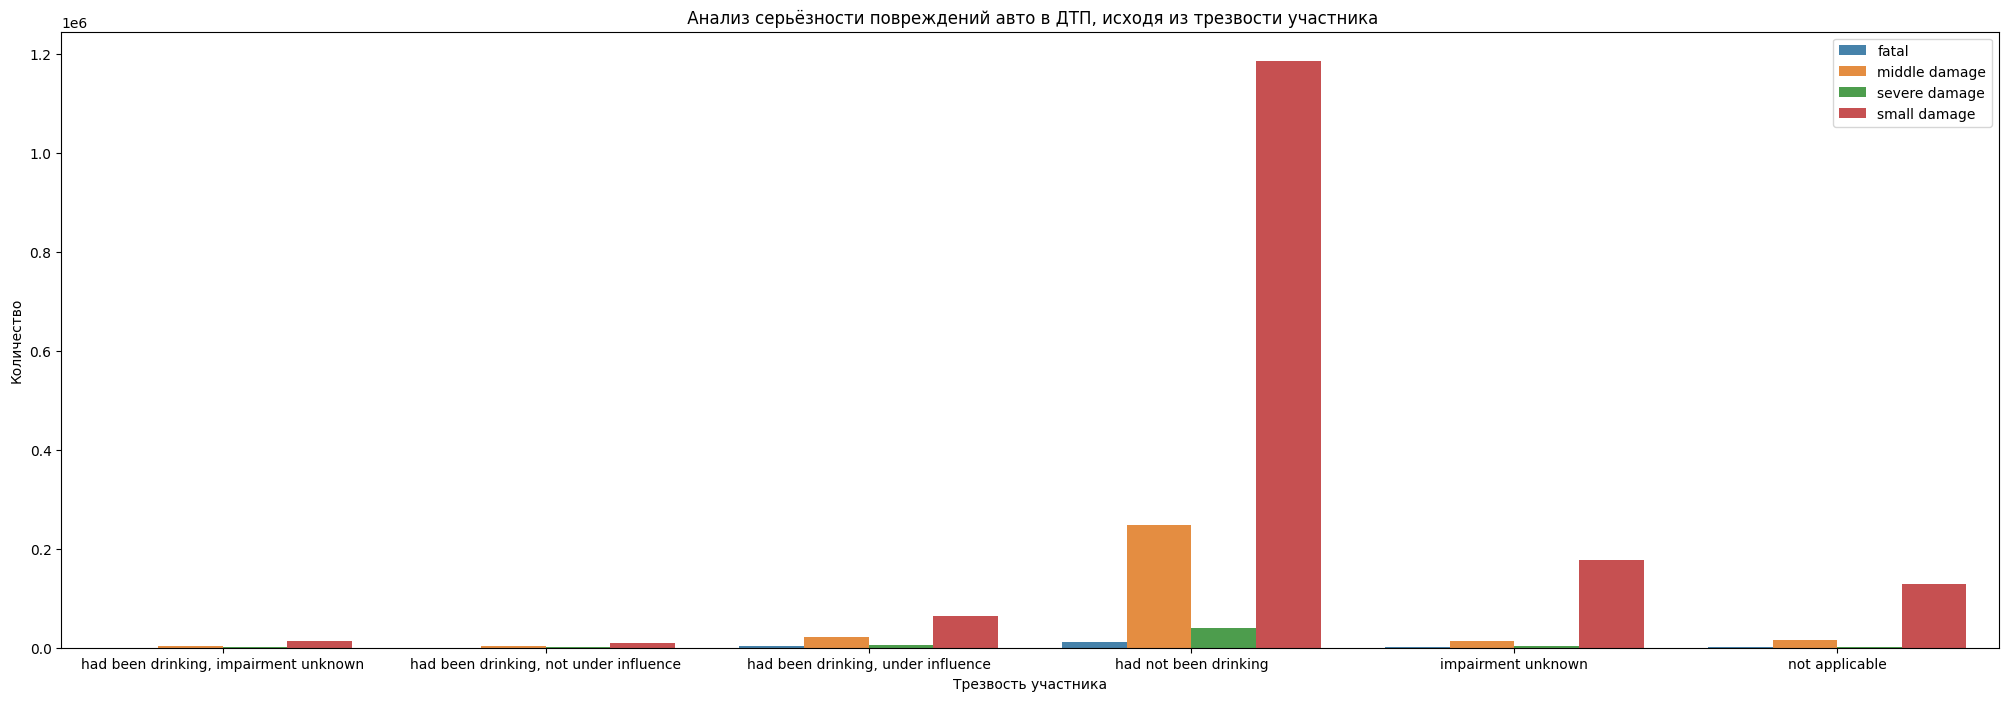

In [11]:
f, ax = plt.subplots(figsize=(25, 8))

sns.barplot(data =sobriety_damage, 
            x='party_sobriety',
            y = 'damage_count',
            hue  = 'collision_damage',
            alpha=0.9)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="Количество")
ax.set(xlabel="Трезвость участника")
plt.title(" Анализ серьёзности повреждений авто в ДТП, исходя из трезвости участника")
plt.show()

Чаще всего учатник аварии не был в состоянии алкогольного опьянения. Однако также мы можем наблюдать, что также есть небольшое количество аварий с водителями с алкогольным опьянением и с неизвестной информацией по водителю. Возможно, последнее связано с тем, что водители, находящиеся в состоянии алкогольного опьянения, чаще покидают место аварии, поскольку чаще являются виновниками.

Анализ серьёзности повреждений ТС в зависимости от года выпуска автомобиля.


- Создайте SQL-запрос (связать vehicles и collisions по полю case_id);
- Сгруппируйте записи и определите количество аварий по возрасту автомобиля.
- Постройте графики для наглядности определения присутствия влияния на серьезность аварий.
- Сделайте вывод.

In [12]:
query = '''
SELECT c.collision_damage,
       v.vehicle_age,
       COUNT(c.collision_damage) as damage_count
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE c.collision_damage != 'scratch'
GROUP BY  c.collision_damage, v.vehicle_age;
'''
age_damage = pd.read_sql_query(query, con=engine)
age_damage

,collision_damage,vehicle_age,damage_count
0,fatal,0.0,229
1,fatal,1.0,241
2,fatal,2.0,814
3,fatal,3.0,2478
4,fatal,4.0,1871
...,...,...,...
73,small damage,15.0,178
74,small damage,16.0,45
75,small damage,17.0,16
76,small damage,18.0,1


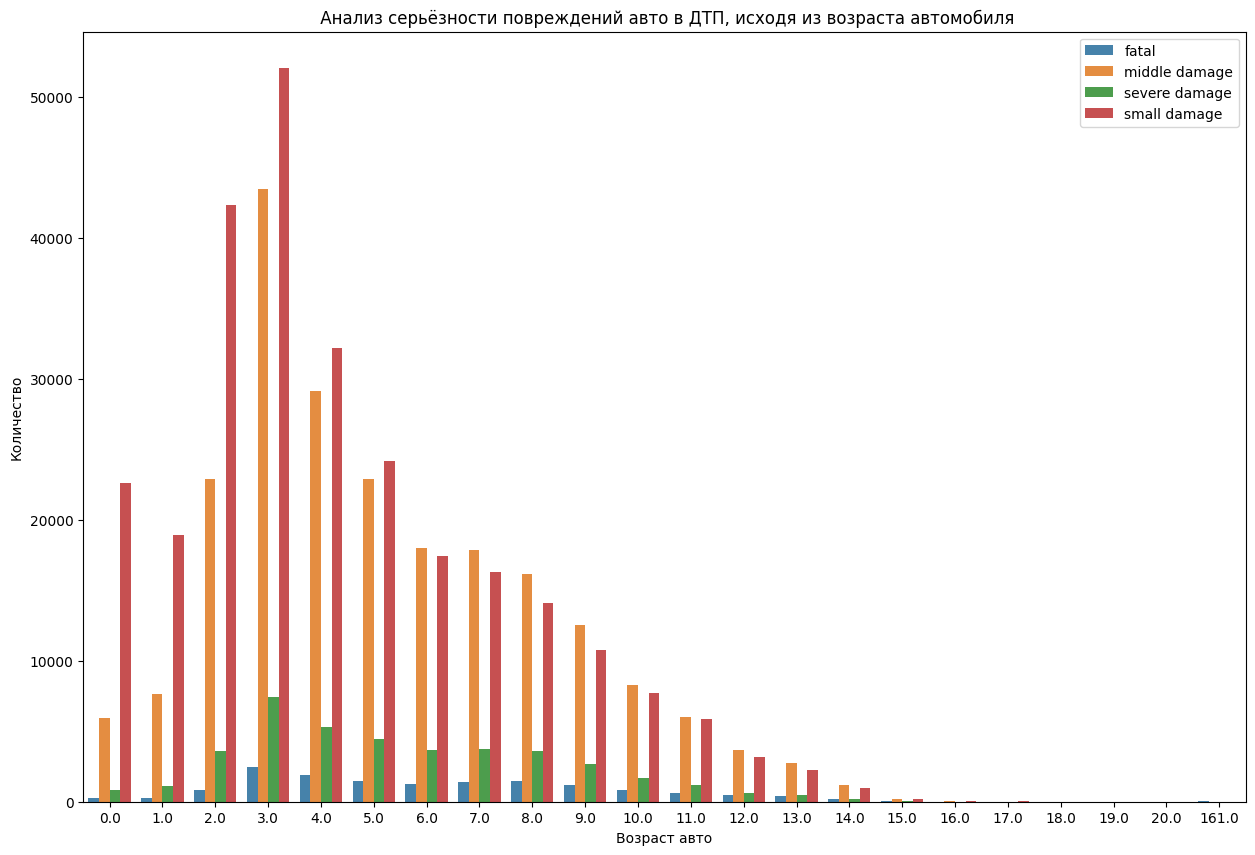

In [13]:
# выведем график
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(data =age_damage, 
            x='vehicle_age',
            y = 'damage_count',
            hue  = 'collision_damage',
            alpha=0.9)
ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="Количество")
ax.set(xlabel="Возраст авто")
plt.title(" Анализ серьёзности повреждений авто в ДТП, исходя из возраста автомобиля")
plt.show()

По годам аварии имеют очертания нормального распределения. Пик приходится на 3 года. Пересекая рубеж в 3 года частота повреждений всех типов уменьшается.\
Новые автомобили до 2 лет, чаще попадают в категорию small damage.\
Наибольшее число ДТП по всем видам повреждений происходить с авто с возрастом 2-4 года.

## Создание модели для оценки водительского риска

### Подготовка данных для оценки водительского риска

In [15]:
query = '''
SELECT 
    c.collision_date, 
    c.collision_time,
    c.intersection,
    c.weather_1,
    c.collision_damage,
    c.primary_collision_factor,
    c.road_surface,
    c.lighting,
    c.county_city_location,
    c.county_location,
    c.direction,
    c.distance,
    c.location_type,
    c.party_count,
    c.pcf_violation_category,
    c.type_of_collision,
    c.motor_vehicle_involved_with,
    c.road_condition_1,
    c.control_device,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
    
FROM collisions c
JOIN parties p ON p.case_id = c.case_id
JOIN vehicles v ON v.case_id = c.case_id AND v.party_number = p.party_number

AND p.party_type = 'car'
AND c.collision_damage <> 'scratch'
AND CAST(EXTRACT('YEAR' FROM collision_date) AS INT) = 2012
'''

data = pd.read_sql_query(query, con=engine)
data.head(10)

,collision_date,collision_time,intersection,weather_1,collision_damage,primary_collision_factor,road_surface,lighting,county_city_location,county_location,direction,distance,location_type,party_count,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_condition_1,control_device,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,2012-04-19,22:04:00,0.0,clear,small damage,vehicle code violation,dry,dark with street lights,3607,san bernardino,north,400.0,None,2,automobile right of way,broadside,other motor vehicle,normal,none,1,43.0,had not been drinking,None,0.0,sedan,auto,8.0
1,2012-01-15,02:00:00,0.0,clear,small damage,vehicle code violation,dry,dark with street lights,0708,contra costa,east,21.0,None,2,dui,rear end,other motor vehicle,normal,functioning,0,54.0,had not been drinking,None,0.0,sedan,manual,10.0
2,2012-04-29,17:10:00,0.0,clear,small damage,vehicle code violation,dry,daylight,3607,san bernardino,west,150.0,None,2,improper turning,broadside,other motor vehicle,None,none,0,27.0,had not been drinking,None,NaN,sedan,auto,3.0
3,2012-04-18,17:15:00,0.0,clear,small damage,vehicle code violation,dry,daylight,1942,los angeles,east,450.0,highway,2,speeding,rear end,other motor vehicle,normal,none,0,52.0,had not been drinking,None,0.0,sedan,auto,10.0
4,2012-05-04,12:50:00,0.0,clear,small damage,vehicle code violation,dry,daylight,3026,orange,north,40.0,None,2,speeding,rear end,other motor vehicle,normal,functioning,1,28.0,had not been drinking,None,0.0,sedan,auto,4.0
5,2012-05-07,13:04:00,1.0,clear,small damage,vehicle code violation,dry,daylight,1900,los angeles,None,0.0,None,2,automobile right of way,broadside,other motor vehicle,normal,functioning,1,45.0,had not been drinking,None,0.0,sedan,auto,0.0
6,2012-03-25,19:50:00,0.0,clear,small damage,vehicle code violation,dry,dark with street lights,0109,alameda,west,1900.0,highway,4,unsafe lane change,sideswipe,other motor vehicle,normal,none,0,20.0,had not been drinking,None,0.0,sedan,auto,0.0
7,2012-04-27,15:50:00,0.0,clear,small damage,vehicle code violation,dry,daylight,3708,san diego,east,506.0,highway,2,speeding,sideswipe,other motor vehicle,normal,none,0,32.0,had not been drinking,None,0.0,sedan,auto,2.0
8,2012-05-18,14:29:00,0.0,clear,middle damage,vehicle code violation,dry,daylight,3404,sacramento,west,210.0,None,2,automobile right of way,rear end,other motor vehicle,normal,none,1,NaN,had not been drinking,None,NaN,sedan,auto,9.0
9,2012-04-29,18:22:00,0.0,clear,small damage,vehicle code violation,dry,daylight,3001,orange,west,175.0,ramp,3,dui,rear end,other motor vehicle,normal,functioning,0,71.0,had not been drinking,None,0.0,sedan,auto,11.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   collision_date               56248 non-null  object 
 1   collision_time               56160 non-null  object 
 2   intersection                 56073 non-null  float64
 3   weather_1                    56080 non-null  object 
 4   collision_damage             56248 non-null  object 
 5   primary_collision_factor     56137 non-null  object 
 6   road_surface                 55900 non-null  object 
 7   lighting                     56094 non-null  object 
 8   county_city_location         56248 non-null  object 
 9   county_location              56248 non-null  object 
 10  direction                    43230 non-null  object 
 11  distance                     56248 non-null  float64
 12  location_type                25932 non-null  object 
 13  party_count     

In [17]:
data.isna().sum()

collision_date                     0
collision_time                    88
intersection                     175
weather_1                        168
collision_damage                   0
primary_collision_factor         111
road_surface                     348
lighting                         154
county_city_location               0
county_location                    0
direction                      13018
distance                           0
location_type                  30316
party_count                        0
pcf_violation_category           766
type_of_collision                308
motor_vehicle_involved_with      162
road_condition_1                 249
control_device                   215
at_fault                           0
insurance_premium                547
party_sobriety                   872
party_drug_physical            53391
cellphone_in_use                4471
vehicle_type                       0
vehicle_transmission             859
vehicle_age                     1694
d

### Первичный отбор факторов, необходимых для модели.

|Обозначение в таблице|Описание|Влияние на вероятность ДТП(+/-)|Целесообразность использования в обучении модели|
|--------|--------|--------|--------|
|at_fault|<p>Виновность участника<p>|<p>+<p>|<p>Таргет для обучения<p>|
|insurance_premium|<p>Сумма страховки<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|party_sobriety|<p>Трезвость участника<p>|<p>-<p>|<p>Выявляется после дтп .<p>|
|party_drug_physical|<p>Состояние участника: физическое или с учётом принятых лекарств<p>|<p>-<p>|<p>Станет известным после дтп<p>|
|cellphone_in_use|<p>Наличие телефона, возможности разговаривать по громкой связи<p>|<p>+<p>|<p>Отсутствие возможности говорить по громной связи способно оказать влияние на риск стать виновником ДТП<p>|
|vehicle_type|<p>Тип кузова<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|vehicle_transmission|<p>Тип КПП<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|vehicle_age|<p>Возраст автомобиля<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|county_city_location|<p>Номер географических районов<p>|<p>-<p>|<p>При использовании этих признаков, будет сложно обобщить результаты модели на районы, в которых ДТП зарегестрированы не были, но потенциально могут быть. К тому же географический признак влияет на вероятность ДТП в зависимости от задаваемого маршрута, но не влияет на вероятность водителя стать виновником, т.к. у невиновного также будет аналогичный признак.<p>|
|county_location|<p>Название географических районов<p>|<p>-<p>|<p>Признак влияет на вероятность ДТП в зависимости от задаваемого маршрута, но не влияет на вероятность водителя стать виновником<p>|
|distance|<p>Растояние от главной дороги<p>|<p>+<p>|<p>Расстояние от главное дороги, может пригодиться на этапе планирования маршрута<p>|
|direction|<p>Направление движения<p>|<p>-<p>|<p>Зависимость направления движения и того, что с водителем может произойти в то время как он будет ехать в этом направлении сильно может зависеть от населенного пункта, а географические данные нам ни к чему<p>|
|intersection|<p>Является ли место проишествия перекрестком<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|weather_1|<p>Погода<p>|<p>+<p>|<p>Погодные условия однозначно могут влиять<p>|
|location_type|<p>Тип дороги<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|collision_damage|<p>Серьёзность проишествия<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|party_count|<p>Количестко участников<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|primary_collision_factor|<p>Основной фактор аварий<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|pcf_violation_category|<p>Категория нарушения<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|type_of_collision|<p>Тип аварии<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|motor_vehicle_involved_with|<p>Дополнительные участники ДТП<p>|<p>-<p>|<p>Является результатом ДТП, а не предпосылкой к ней (невозможно определить заранее)<p>|
|road_surface|<p>Состояние дороги<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|road_condition_1|<p>Дорожное состояние<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|lighting|<p>Освещение<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|control_device|<p>Устройство управления<p>|<p>+<p>|<p>В зависимости от авто или состояния водителя способно оказать влияние на риск стать виновником ДТП<p>|
|collision_date|<p>Дата проишествия<p>|<p>-<p>|<p>Не будем использовать, т.к. данные по месяцам распределены не равномерно. После июня данные практически отсутсвуют. Можно было-бы вытащить времена года, но в экваториальнеых районах нет сезонности, а в другом полушарии они вообще инвертированы. И к тому же время года посути может влиять на освещение, погодные условия и состояние дороги, а эти признаки есть в датасете <p>|
|collision_time|<p>Время проишествия<p>|<p>+<p>|<p>Может влиять, так как в определенные часы на дорогах может быть больше либо меньше машин<p>|

In [18]:
columms = [
    'cellphone_in_use',
    'vehicle_type',
    'vehicle_transmission',
    'vehicle_age',
    'distance',
    'intersection',
    'weather_1',
    'location_type',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'at_fault'

]

In [19]:
df = data[columms].copy()

In [20]:
df.head()

,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,distance,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,at_fault
0,0.0,sedan,auto,8.0,400.0,0.0,clear,None,dry,normal,dark with street lights,none,1
1,0.0,sedan,manual,10.0,21.0,0.0,clear,None,dry,normal,dark with street lights,functioning,0
2,NaN,sedan,auto,3.0,150.0,0.0,clear,None,dry,None,daylight,none,0
3,0.0,sedan,auto,10.0,450.0,0.0,clear,highway,dry,normal,daylight,none,0
4,0.0,sedan,auto,4.0,40.0,0.0,clear,None,dry,normal,daylight,functioning,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cellphone_in_use      51777 non-null  float64
 1   vehicle_type          56248 non-null  object 
 2   vehicle_transmission  55389 non-null  object 
 3   vehicle_age           54554 non-null  float64
 4   distance              56248 non-null  float64
 5   intersection          56073 non-null  float64
 6   weather_1             56080 non-null  object 
 7   location_type         25932 non-null  object 
 8   road_surface          55900 non-null  object 
 9   road_condition_1      55999 non-null  object 
 10  lighting              56094 non-null  object 
 11  control_device        56033 non-null  object 
 12  at_fault              56248 non-null  int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 5.6+ MB


In [22]:
df.isna().sum()

cellphone_in_use         4471
vehicle_type                0
vehicle_transmission      859
vehicle_age              1694
distance                    0
intersection              175
weather_1                 168
location_type           30316
road_surface              348
road_condition_1          249
lighting                  154
control_device            215
at_fault                    0
dtype: int64

In [23]:
df.duplicated().sum()

17932

In [24]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Рассмотрим каждым признак.

**cellphone_in_use**

In [25]:
df['cellphone_in_use'].isna().sum()

3487

In [26]:
f"Пропуски составляют: {(df['cellphone_in_use'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 6.2%'

Заполним пропуски `-1`

In [27]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(-1)

In [28]:
df['cellphone_in_use'].value_counts()

cellphone_in_use
 0.0    33815
-1.0     3487
 1.0     1014
Name: count, dtype: int64

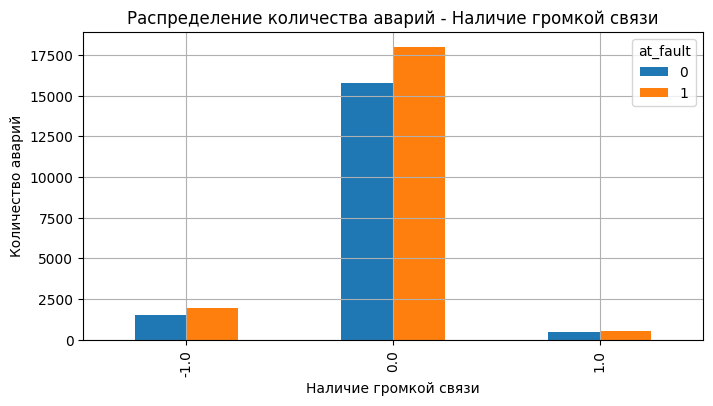

In [29]:
df.pivot_table(
    index='cellphone_in_use', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Наличие громкой связи', 
    xlabel='Наличие громкой связи', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

У очень маленького количества автомобилей есть такая возможность. Очень странно для 2012 года.

**vehicle_type**

In [30]:
df['vehicle_type'].isna().sum()

0

In [31]:
df['vehicle_type'].value_counts()

vehicle_type
sedan    24435
coupe    13877
other        4
Name: count, dtype: int64

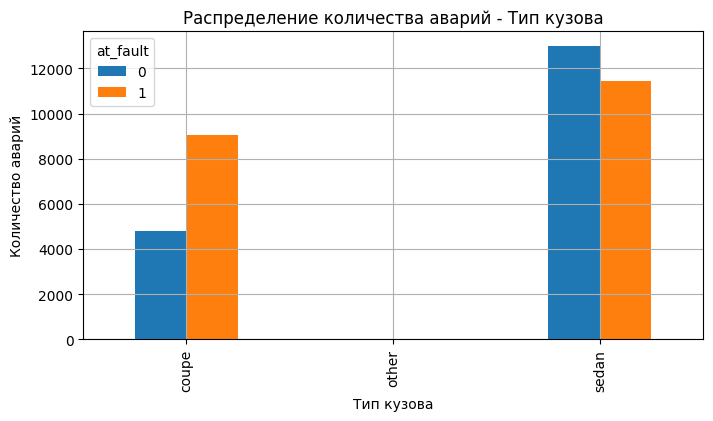

In [32]:
df.pivot_table(
    index='vehicle_type', 
    columns='at_fault', 
    values='distance', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Тип кузова', 
    xlabel='Тип кузова', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

**vehicle_transmission**

In [33]:
df['vehicle_transmission'].isna().sum()

749

In [34]:
f"Пропуски составляют: {(df['vehicle_transmission'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 1.33%'

Можно удалить данные с пропуском

In [35]:
df.dropna(subset=['vehicle_transmission'], inplace=True)

In [36]:
df['vehicle_transmission'].isna().sum()

0

In [37]:
df['vehicle_transmission'].value_counts()

vehicle_transmission
manual    20149
auto      17418
Name: count, dtype: int64

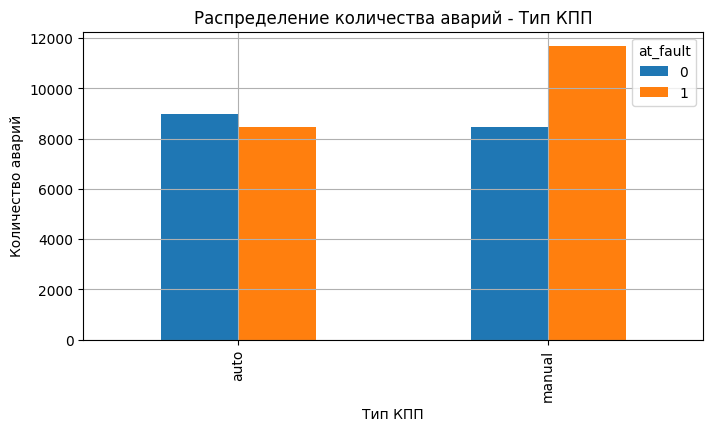

In [38]:
df.pivot_table(
    index='vehicle_transmission', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Тип КПП', 
    xlabel='Тип КПП', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

Водители с МКПП чаще становятся виновниками аварии нежели с АКПП.

**vehicle_age**

In [39]:
df['vehicle_age'].isna().sum()

1034

In [40]:
f"Пропуски составляют: {(df['vehicle_age'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 1.84%'

In [41]:
df['vehicle_age'].value_counts()

vehicle_age
3.0      6828
4.0      4736
2.0      3805
5.0      3785
6.0      2739
7.0      2715
8.0      2447
9.0      1963
0.0      1948
1.0      1637
10.0     1487
11.0     1048
12.0      698
13.0      428
14.0      226
15.0       33
16.0        5
17.0        2
161.0       2
19.0        1
Name: count, dtype: int64

#Наблюдается аномальный возраст 161 год. Избавимся от этих данных.

Наблюдается аномальный возраст 161 год. Скорее всего сдесь допученна ошибка при заполнении данных таблицы, связанная с человеческим фактором. Заменим 161 на 16 в train после разбиения на выборки.

In [43]:
df['vehicle_age'].value_counts()

vehicle_age
3.0      6828
4.0      4736
2.0      3805
5.0      3785
6.0      2739
7.0      2715
8.0      2447
9.0      1963
0.0      1948
1.0      1637
10.0     1487
11.0     1048
12.0      698
13.0      428
14.0      226
15.0       33
16.0        5
17.0        2
161.0       2
19.0        1
Name: count, dtype: int64

Так же удалим пропуски которые составляют 2%

In [44]:
df.dropna(subset=['vehicle_age'], inplace=True)

In [45]:
df['vehicle_age'].isna().sum()

0

**distance**

In [46]:
df['distance'].isna().sum()

0

In [47]:
df['distance'].describe()

count    3.653300e+04
mean     1.093342e+03
std      8.937322e+03
min      0.000000e+00
25%      4.000000e+01
50%      2.000000e+02
75%      7.500000e+02
max      1.584000e+06
Name: distance, dtype: float64

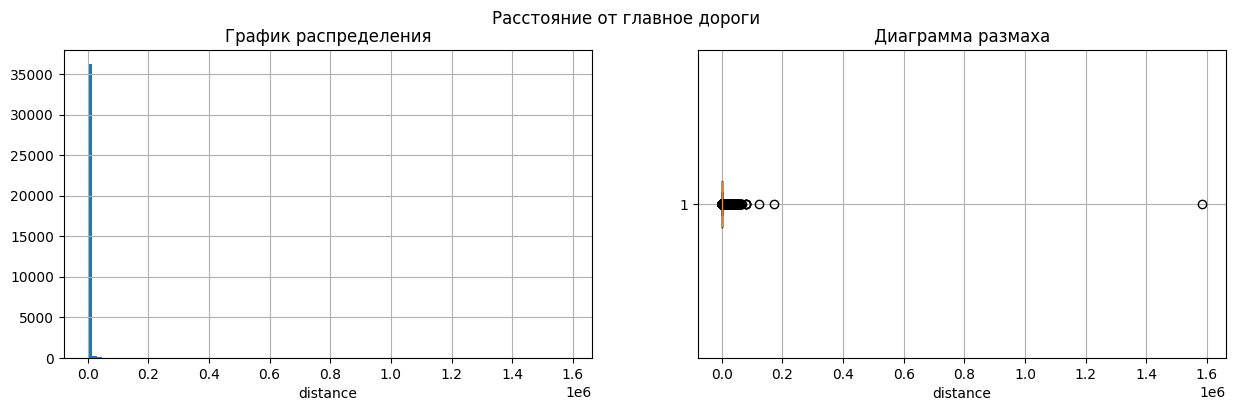

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Расстояние от главное дороги')

ax[0].hist(df['distance'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('distance')
ax[0].grid()

ax[1].boxplot(df['distance'].dropna(), vert=False)
ax[1].set_title('Диаграмма размаха')
ax[1].set_xlabel('distance')
ax[1].grid()

Присутствует один аномально большой выброс. уберем его и посмотрим да графики.

In [49]:
df = df.loc[df['distance'] != df['distance'].max()]

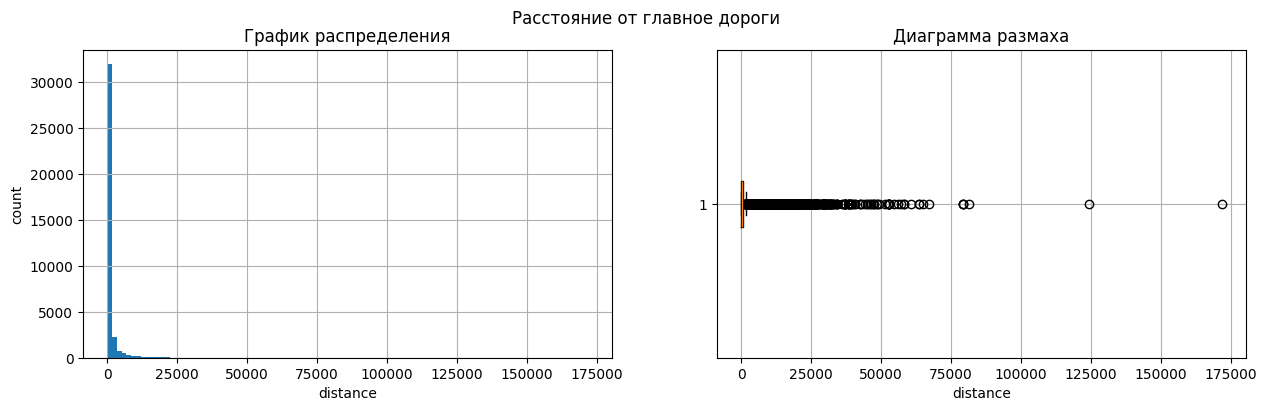

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Расстояние от главное дороги')

ax[0].hist(df['distance'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('distance')
ax[0].set_ylabel('count')
ax[0].grid()

ax[1].boxplot(df['distance'].dropna(), vert=False)
ax[1].set_title('Диаграмма размаха')
ax[1].set_xlabel('distance')
ax[1].grid()

По прежнему есть большие выбросы. Ограничимся расстояние в 5000км.

In [51]:
df = df.loc[df['distance'] <=5000].reset_index(drop=True)

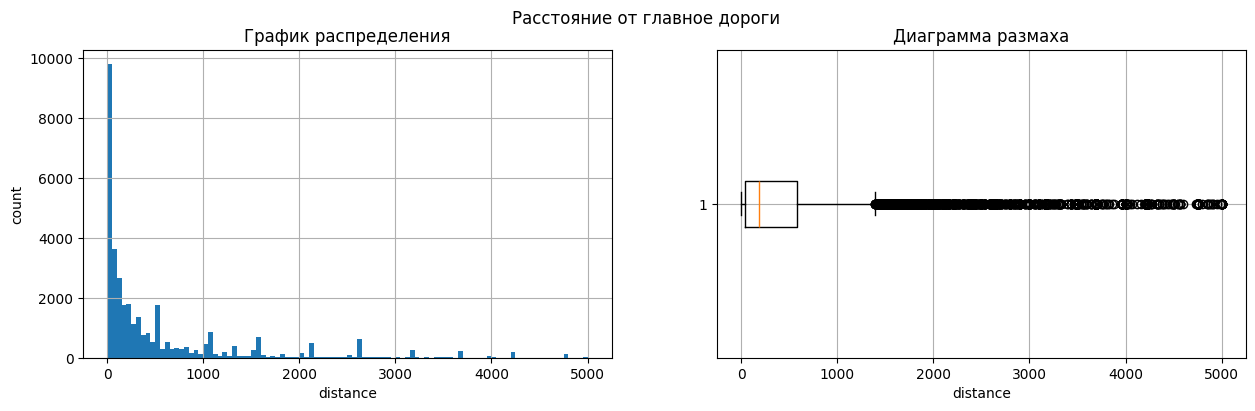

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Расстояние от главное дороги')

ax[0].hist(df['distance'], bins=100)
ax[0].set_title('График распределения')
ax[0].set_xlabel('distance')
ax[0].set_ylabel('count')
ax[0].grid()

ax[1].boxplot(df['distance'].dropna(), vert=False)
ax[1].set_title('Диаграмма размаха')
ax[1].set_xlabel('distance')
ax[1].grid()

**intersection**

In [53]:
df['intersection'].isna().sum()

154

In [54]:
f"Пропуски составляют: {(df['intersection'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 0.27%'

Удалим пропуски.

In [55]:
df.dropna(subset=['intersection'], inplace=True)

In [56]:
df['intersection'].isna().sum()

0

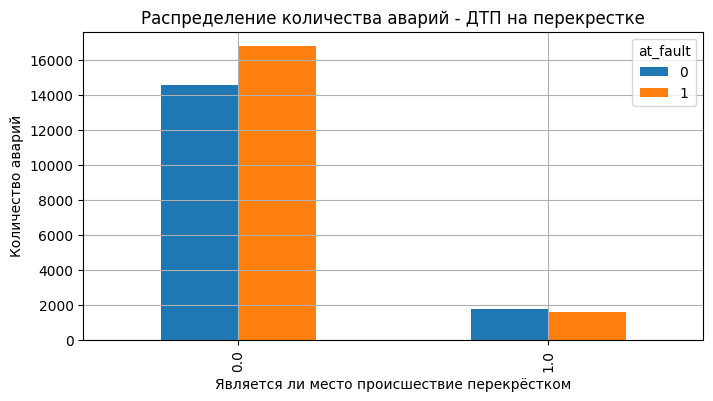

In [57]:
df.pivot_table(
    index='intersection', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - ДТП на перекрестке', 
    xlabel='Является ли место происшествие перекрёстком', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

Большенство аварий были вне перекрестков.

**weather_1**

По скольку других столбцов с погодой у нас нет, можно переименовать этот столбец.

In [58]:
df = df.rename(columns={'weather_1': 'weather'})

In [59]:
df['weather'].isna().sum()

161

In [60]:
f"Пропуски составляют: {(df['weather'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 0.29%'

Процент пропусков не велик, удалим данные.

In [61]:
df.dropna(subset=['weather'], inplace=True)

In [62]:
df['weather'].isna().sum()

0

In [63]:
df['weather'].value_counts()

weather
clear      25716
cloudy      6632
raining     1864
fog          156
snowing      123
other         25
wind          11
Name: count, dtype: int64

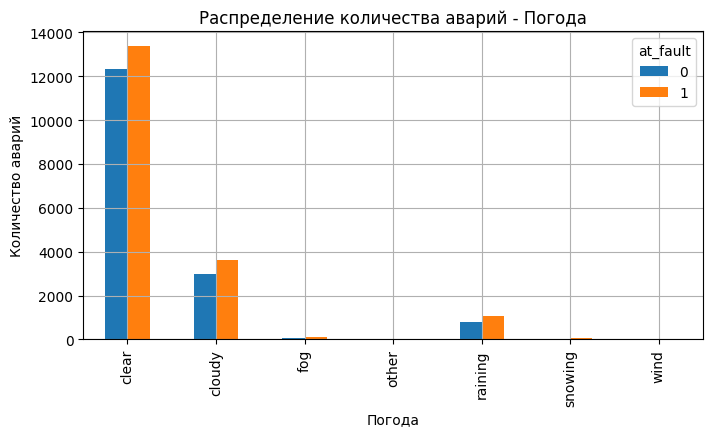

In [64]:
df.pivot_table(
    index='weather', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Погода', 
    xlabel='Погода', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

Видно, что большинство случаев произошло в ясную и облачную погоду, меньше происшествий в дождливую погоду. Думаю что туман, снег и ветер можно добавить в категорию "другие", по скольку их количество очень мало.

In [65]:
df.loc[(df['weather'] == 'fog') | (df['weather'] == 'snowing') | (df['weather'] == 'wind'), 'weather'] = 'other'

In [66]:
df['weather'].value_counts()

weather
clear      25716
cloudy      6632
raining     1864
other        315
Name: count, dtype: int64

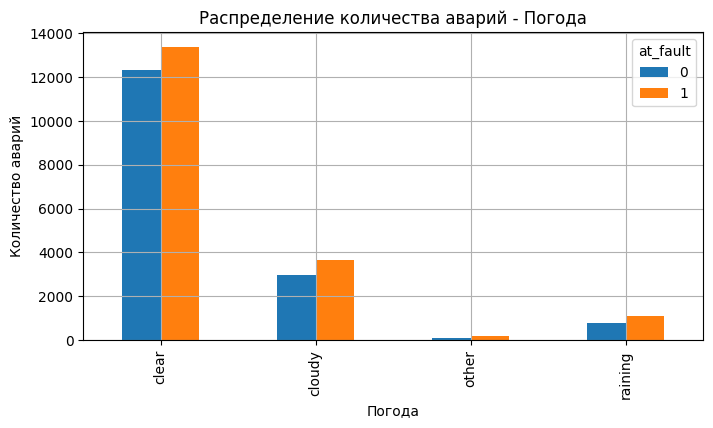

In [67]:
df.pivot_table(
    index='weather', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Погода', 
    xlabel='Погода', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

**location_type**

In [68]:
df['location_type'].isna().sum()

17890

In [69]:
f"Пропуски составляют: {(df['location_type'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 31.81%'

Присутствует очень большое количество пропусков. Думаю лучше отказаться от этого столбца.

In [70]:
df = df.drop(columns=['location_type'], axis =1)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34527 entries, 0 to 34841
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cellphone_in_use      34527 non-null  float64
 1   vehicle_type          34527 non-null  object 
 2   vehicle_transmission  34527 non-null  object 
 3   vehicle_age           34527 non-null  float64
 4   distance              34527 non-null  float64
 5   intersection          34527 non-null  float64
 6   weather               34527 non-null  object 
 7   road_surface          34278 non-null  object 
 8   road_condition_1      34353 non-null  object 
 9   lighting              34426 non-null  object 
 10  control_device        34366 non-null  object 
 11  at_fault              34527 non-null  int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 3.4+ MB


**road_surface**

In [72]:
df['road_surface'].isna().sum()

249

In [73]:
f"Пропуски составляют: {(df['road_surface'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 0.44%'

Удалим пропуски.

In [74]:
df.dropna(subset=['road_surface'], inplace=True)

In [75]:
df['road_surface'].value_counts()

road_surface
dry         29527
wet          4428
snowy         285
slippery       38
Name: count, dtype: int64

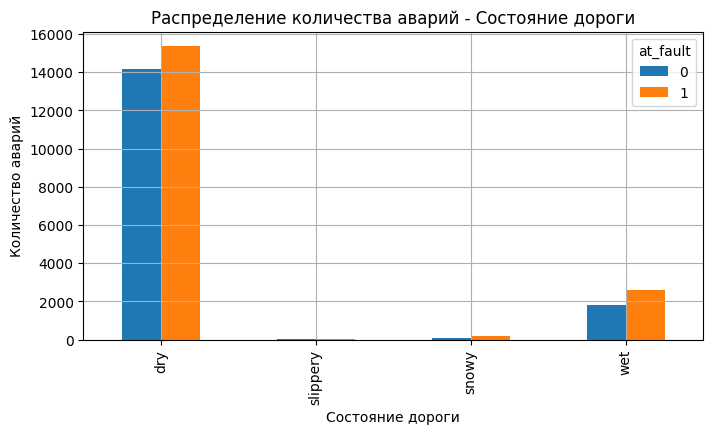

In [76]:
df.pivot_table(
    index='road_surface', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Состояние дороги', 
    xlabel='Состояние дороги', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

Большинство аварий происходит на сухой дороге.

**road_condition_1**

Изменим название столбца

In [77]:
df = df.rename(columns={'road_condition_1': 'road_condition'})

In [78]:
df['road_condition'].isna().sum()

165

In [79]:
f"Пропуски составляют: {(df['road_condition'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 0.29%'

Удалим пропуски

In [80]:
df.dropna(subset=['road_condition'], inplace=True)

In [81]:
df['road_condition'].isna().sum()

0

In [82]:
df['road_condition'].value_counts()

road_condition
normal            32501
construction        895
obstruction         215
other               198
holes               119
loose material      100
reduced width        55
flooded              30
Name: count, dtype: int64

**lighting**

In [83]:
df['lighting'].isna().sum()

91

In [84]:
f"Пропуски составляют: {(df['lighting'].isna().sum()/len(data)*100).round(2)}%"


'Пропуски составляют: 0.16%'

Удалим пропуски

In [85]:
df.dropna(subset=['lighting'], inplace=True)

In [86]:
df['lighting'].isna().sum()

0

In [87]:
df['lighting'].value_counts()

lighting
daylight                                   21411
dark with street lights                     7288
dark with no street lights                  3783
dusk or dawn                                1414
dark with street lights not functioning      126
Name: count, dtype: int64

**control_device**

In [88]:
df['control_device'].isna().sum()

151

In [89]:
f"Пропуски составляют: {(df['control_device'].isna().sum()/len(data)*100).round(2)}%"

'Пропуски составляют: 0.27%'

Удалим пропуски

In [90]:
df.dropna(subset=['control_device'], inplace=True)

In [91]:
df['control_device'].isna().sum()

0

In [92]:
df['control_device'].value_counts()

control_device
none               24528
functioning         9218
not functioning      100
obscured              25
Name: count, dtype: int64

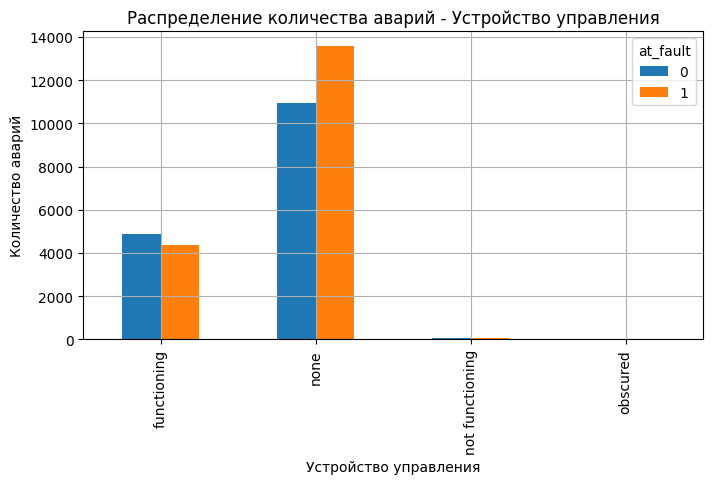

In [93]:
df.pivot_table(
    index='control_device', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий - Устройство управления', 
    xlabel='Устройство управления', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

**at_fault**

In [94]:
df['at_fault'].isna().sum()

0

In [95]:
df['at_fault'].value_counts()

at_fault
1    17989
0    15882
Name: count, dtype: int64

Соотношение классов сбалансированно

In [96]:
df=df.reset_index(drop=True)

In [97]:
df.head(10)

,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,distance,intersection,weather,road_surface,road_condition,lighting,control_device,at_fault
0,0.0,sedan,auto,8.0,400.0,0.0,clear,dry,normal,dark with street lights,none,1
1,0.0,sedan,manual,10.0,21.0,0.0,clear,dry,normal,dark with street lights,functioning,0
2,0.0,sedan,auto,10.0,450.0,0.0,clear,dry,normal,daylight,none,0
3,0.0,sedan,auto,4.0,40.0,0.0,clear,dry,normal,daylight,functioning,1
4,0.0,sedan,auto,0.0,0.0,1.0,clear,dry,normal,daylight,functioning,1
5,0.0,sedan,auto,0.0,1900.0,0.0,clear,dry,normal,dark with street lights,none,0
6,0.0,sedan,auto,2.0,506.0,0.0,clear,dry,normal,daylight,none,0
7,-1.0,sedan,auto,9.0,210.0,0.0,clear,dry,normal,daylight,none,1
8,0.0,sedan,auto,11.0,175.0,0.0,clear,dry,normal,daylight,functioning,0
9,0.0,sedan,auto,1.0,0.0,1.0,cloudy,dry,normal,daylight,functioning,0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33871 entries, 0 to 33870
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cellphone_in_use      33871 non-null  float64
 1   vehicle_type          33871 non-null  object 
 2   vehicle_transmission  33871 non-null  object 
 3   vehicle_age           33871 non-null  float64
 4   distance              33871 non-null  float64
 5   intersection          33871 non-null  float64
 6   weather               33871 non-null  object 
 7   road_surface          33871 non-null  object 
 8   road_condition        33871 non-null  object 
 9   lighting              33871 non-null  object 
 10  control_device        33871 non-null  object 
 11  at_fault              33871 non-null  int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 3.1+ MB


### Проверка на мультиколлинеарность

In [99]:
continuous_features = ['vehicle_age', 'distance']
phik_overview = df.phik_matrix(interval_cols=continuous_features)

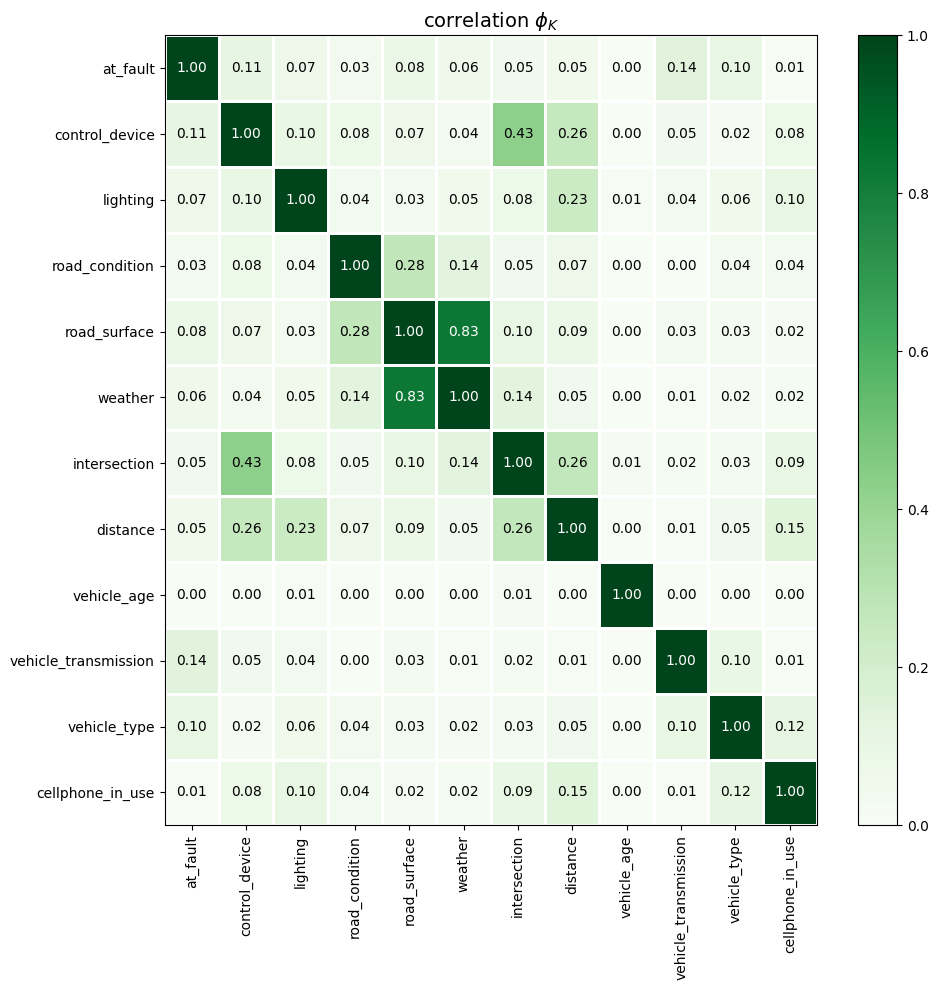

In [100]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

У признака `weather` наблюдается сильная корреляция с признаком `road_surface`, оставим наиболее значимый признак `road_surface`.\
#Признак `vehicle_age` не имеет корреляции с целевым признаком, но мы его оставим, т.к. заказчик поставил обязательное условие — учесть фактор возраста автомобиля.

In [ ]:
df = df.drop(columns=['weather'], axis =1)

**Вывод**
Все столбцы подготовлены, лишние убраны, пропусков нет. Из изначальных 27 столбцов осталось 11:
- cellphone_in_use
- vehicle_type
- vehicle_transmission
- vehicle_age
- distance 
- intersection
- road_surface
- road_condition 
- lighting
- control_device 
- at_fault

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33871 entries, 0 to 33870
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cellphone_in_use      33871 non-null  float64
 1   vehicle_type          33871 non-null  object 
 2   vehicle_transmission  33871 non-null  object 
 3   vehicle_age           33871 non-null  float64
 4   distance              33871 non-null  float64
 5   intersection          33871 non-null  float64
 6   road_surface          33871 non-null  object 
 7   road_condition        33871 non-null  object 
 8   lighting              33871 non-null  object 
 9   control_device        33871 non-null  object 
 10  at_fault              33871 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 2.8+ MB


## Разбитие на выборки, кодировка и масштабирование данных

In [103]:
cat_columns = df.select_dtypes('object').columns

In [104]:
df[cat_columns] = df[cat_columns].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33871 entries, 0 to 33870
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   cellphone_in_use      33871 non-null  float64 
 1   vehicle_type          33871 non-null  category
 2   vehicle_transmission  33871 non-null  category
 3   vehicle_age           33871 non-null  float64 
 4   distance              33871 non-null  float64 
 5   intersection          33871 non-null  float64 
 6   road_surface          33871 non-null  category
 7   road_condition        33871 non-null  category
 8   lighting              33871 non-null  category
 9   control_device        33871 non-null  category
 10  at_fault              33871 non-null  int64   
dtypes: category(6), float64(4), int64(1)
memory usage: 1.5 MB


In [105]:
RANDOM_STATE=30400

In [106]:
X = df.drop('at_fault', axis=1)
y = df['at_fault']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = RANDOM_STATE, stratify=y)

In [108]:
X_train['vehicle_age'].value_counts()

vehicle_age
3.0      5076
4.0      3496
2.0      2838
5.0      2775
7.0      2050
6.0      2048
8.0      1780
0.0      1475
9.0      1463
1.0      1192
10.0     1082
11.0      782
12.0      516
13.0      312
14.0      180
15.0       23
16.0        4
161.0       2
17.0        1
19.0        1
Name: count, dtype: int64

In [109]:
X_train.loc[(X_train['vehicle_age'] == 161), 'vehicle_age'] = 16

In [110]:
X_train['vehicle_age'].value_counts()

vehicle_age
3.0     5076
4.0     3496
2.0     2838
5.0     2775
7.0     2050
6.0     2048
8.0     1780
0.0     1475
9.0     1463
1.0     1192
10.0    1082
11.0     782
12.0     516
13.0     312
14.0     180
15.0      23
16.0       6
17.0       1
19.0       1
Name: count, dtype: int64

In [111]:
numeric = X.select_dtypes(include=['float64', 'int64']).columns
categorical = X.select_dtypes(exclude=['float64', 'int64']).columns
print(numeric)
categorical

Index(['cellphone_in_use', 'vehicle_age', 'distance', 'intersection'], dtype='object')


Index(['vehicle_type', 'vehicle_transmission', 'road_surface',
       'road_condition', 'lighting', 'control_device'],
      dtype='object')

Кодирование признаков для LogisticRegression

In [112]:
X_train_LR = X_train.copy()
X_test_LR = X_test.copy()


In [113]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train_LR[categorical])

X_train_LR[encoder.get_feature_names_out()] = encoder.transform(X_train_LR[categorical]) 
X_train_LR = X_train_LR.drop(categorical, axis=1)

X_test_LR[encoder.get_feature_names_out()] = encoder.transform(X_test_LR[categorical])
X_test_LR = X_test_LR.drop(categorical, axis=1)

In [114]:
X_train_LR.head(3)

,cellphone_in_use,vehicle_age,distance,intersection,vehicle_type_other,vehicle_type_sedan,vehicle_transmission_manual,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_flooded,road_condition_holes,road_condition_loose material,road_condition_normal,road_condition_obstruction,road_condition_other,road_condition_reduced width,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,control_device_none,control_device_not functioning,control_device_obscured
3217,0.0,5.0,22.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
23017,0.0,3.0,1320.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
18500,0.0,4.0,485.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Масштабирование числовых признаков

In [115]:
column = X_train_LR.columns
scaler = StandardScaler()
X_train_LR[numeric] = scaler.fit_transform(X_train_LR[numeric])
X_test_LR[numeric] = scaler.transform(X_test_LR[numeric])

In [116]:
X_train_LR.head(3)

,cellphone_in_use,vehicle_age,distance,intersection,vehicle_type_other,vehicle_type_sedan,vehicle_transmission_manual,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_flooded,road_condition_holes,road_condition_loose material,road_condition_normal,road_condition_obstruction,road_condition_other,road_condition_reduced width,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,control_device_none,control_device_not functioning,control_device_obscured
3217,0.175115,-0.013793,-0.608726,-0.318252,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
23017,0.175115,-0.643520,0.930171,-0.318252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
18500,0.175115,-0.328657,-0.059797,-0.318252,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Кодирование признаков для RandomForest

In [117]:
X_train_RF = X_train.copy()
X_test_RF = X_test.copy()

In [118]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_RF[categorical] = encoder.fit_transform(X_train_RF[categorical])
X_test_RF[categorical] = encoder.transform(X_test_RF[categorical])

Масштабирование числовых признаков

In [119]:
scaler = StandardScaler()
X_train_RF[numeric] = scaler.fit_transform(X_train_RF[numeric])
X_test_RF[numeric] = scaler.transform(X_test_RF[numeric])

In [120]:
X_train_RF.head(3)

,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,distance,intersection,road_surface,road_condition,lighting,control_device
3217,0.175115,2.0,1.0,-0.013793,-0.608726,-0.318252,0.0,4.0,3.0,1.0
23017,0.175115,2.0,0.0,-0.643520,0.930171,-0.318252,0.0,4.0,1.0,1.0
18500,0.175115,0.0,0.0,-0.328657,-0.059797,-0.318252,3.0,4.0,0.0,1.0


## Модели

Для решения данной задачи будем использовать будем использовать следующие модели:
- LogisticRegression
- RandomForestClassifier
- CatBoostClassifier


В качестве метрики будет взято `f1`, т.к. в рамках поставленной задачи нам важны как точность, так и полнота. а она позволяет найти баланс между ними.

### LogisticRegression

In [121]:
warnings.filterwarnings("ignore")
parametrs = {
    "max_iter": range(100,900,100),
    "penalty": ['l1', 'l2', 'elasticnet', 'none']
    }
model_LR = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE),
                        parametrs,
                        verbose = 3,
                        cv=5,
                        scoring = 'f1')

In [122]:
model_LR.fit(X_train_LR, y_train)
display(model_LR.best_params_)
display(model_LR.best_score_)
best_score_LR = model_LR.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ............max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ............max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ............max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ............max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ............max_iter=100, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ..........max_iter=100, penalty=l2;, score=0.639 total time=   0.0s
[CV 2/5] END ..........max_iter=100, penalty=l2;, score=0.627 total time=   0.0s
[CV 3/5] END ..........max_iter=100, penalty=l2;, score=0.627 total time=   0.0s
[CV 4/5] END ..........max_iter=100, penalty=l2;, score=0.641 total time=   0.0s
[CV 5/5] END ..........max_iter=100, penalty=l2;, score=0.642 total time=   0.0s
[CV 1/5] END ....max_iter=100, penalty=elasticnet;, score=nan total time=   0.0s
[CV 2/5] END ....max_iter=100, penalty=elasticn

{'max_iter': 100, 'penalty': 'l2'}

0.6352109699478399

F1 = 0.63, не плохой результат, посмотрим как себя поведут другие модели.

### RandomForestClassifier

In [123]:
parametrs = {
    'n_estimators': [5, 10, 20],  
    'max_depth': [5, 10, 20]
     
}


model_forest = GridSearchCV(RandomForestClassifier(random_state= RANDOM_STATE, class_weight='balanced'),
                            param_grid=parametrs,
                            scoring= 'f1',
                            cv=5, 
                            verbose=3,
                            n_jobs=-1)

model_forest.fit(X_train_RF, y_train)

print("Лучшие параметры модели:")
print(model_forest.best_params_)
print("Лучшее значение F1:")
print(model_forest.best_score_)
best_score_forest = model_forest.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие параметры модели:
{'max_depth': 5, 'n_estimators': 5}
Лучшее значение F1:
0.5961748522595148


F1 = 0.59, хуже чем регресия.

### CatBoostClassifier

In [124]:
cat_features = ['vehicle_type', 'vehicle_transmission', 
                'road_surface', 'road_condition', 'lighting', 'control_device']

In [125]:
parametrs = {
    'depth': [10, 50],  
    'learning_rate': [0.8, 1.0],  
    'iterations': [10, 100]
}


model_cbc = GridSearchCV(CatBoostClassifier(random_state = RANDOM_STATE,
                    cat_features=cat_features,                  
                    auto_class_weights='Balanced',    
                    verbose=False),
                    param_grid=parametrs,
                    scoring='f1', 
                    cv=5, 
                    verbose=3, 
                    n_jobs=-1)

model_cbc.fit(X_train, y_train)

print("Лучшие параметры модели CatBoost:")
print(model_cbc.best_params_)
print("Лучшее значение F1:")
print(model_cbc.best_score_)
best_score_cbc = model_cbc.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры модели CatBoost:
{'depth': 10, 'iterations': 10, 'learning_rate': 1.0}
Лучшее значение F1:
0.599420922020031


Метрика очень близка к лесу F1 = 0.60.

Соберем результаты работы моделей в одну таблицу

In [126]:
dt = {'model': ['LogisticRegression', 'CatBoostClassifier', 'RandomForestClassifier'],
        'f1_score_cross_val': [best_score_LR, best_score_cbc, best_score_forest]}

models_results = pd.DataFrame(dt)
models_results

,model,f1_score_cross_val
0,LogisticRegression,0.635211
1,CatBoostClassifier,0.599421
2,RandomForestClassifier,0.596175


Таким образом, лучше всего обучилась модель `LogisticRegression`, выберем ее для финального тестирования.

In [127]:
model = LogisticRegression(random_state=RANDOM_STATE,
                              max_iter = 100,
                              penalty = 'l2')

model.fit(X_train_LR, y_train)
predict = model.predict(X_test_LR)
f1 = f1_score(y_test, predict)

display(f'F1 {f1}')

'F1 0.6294873493177905'

Мы видим, что наша модель показывает значения метрики`F1 = 0.63`. Показатель не велик учитывая, что для данного проекта нам важнее правильно предсказывать именно виновника аварии.

Проверим модель на адекватность

In [128]:
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
dummy_f1_score = f1_score(y_test, y_pred_dummy, average='weighted')

print(f"F1-score константной модели: {dummy_f1_score:.4f}")

F1-score константной модели: 0.3684


Разница между F1 нашей модели и константной — около 0.26. Это говорит о том, что выбор модели оправдан.

Выведем полноту и точность на график по результатам обучения.

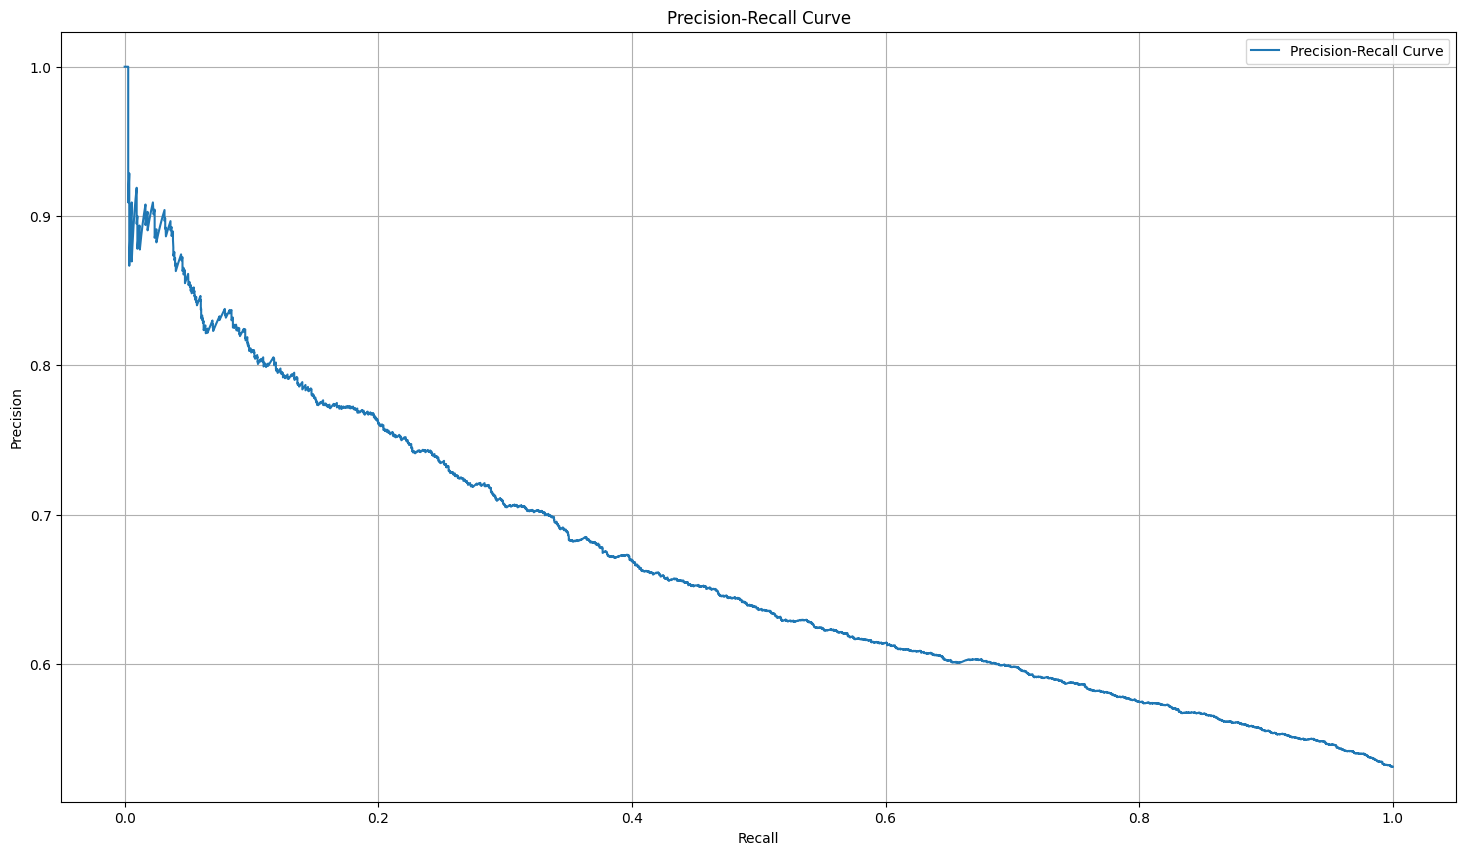

In [129]:
y_scores = model.predict_proba(X_test_LR)[:, 1]

# Вычисление Precision, Recall и пороговых значений
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Вывод графика Precision-Recall Curve
plt.figure(figsize=(18, 10))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

В целом, мы можем наблюдать планомерное снижение точности в угоду полноте, есть некоторые всплески и падения непосредственно перед абсолютной Точностью и абсолютной Полнотой, но они несущественны.

Проведем графический анализ «Матрица ошибок»

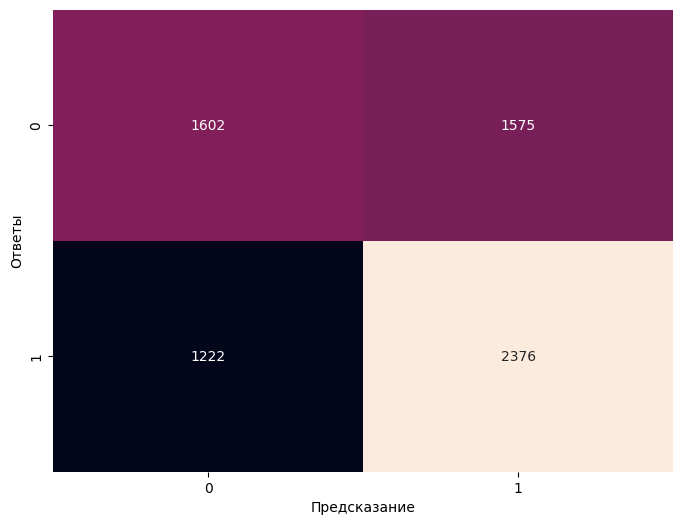

In [130]:
cm = confusion_matrix(y_test, predict)
# Визуализация матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Предсказание')
plt.ylabel('Ответы')
plt.show()

- True Negative: Модель правильно предсказала отсутствие ДТП в 1674 случаях.  Система правильно оценила, что на данном участке или в данный момент риск ДТП отсутствует, и реальных происшествий не произошло. Это указывает на высокую точность в предсказании безопасных ситуаций и, возможно, снижает количество ненужных тревожных сигналов.
- False Positive: В 1503 случае модель ошибочно предсказала наличие ДТП, когда его на самом деле не было. Такие ложные срабатывания могут приводить к ненужным мерам предосторожности, излишним ресурсным затратам или даже к отклонению водителя от оптимального маршрута.
- False Negative: В 1232 случаях модель не определила высокий риск ДТП, и происшествие произошло. Это критические ошибки, так как система не смогла предупредить водителя о потенциальной опасности. Снижение FN важно для повышения безопасности, поскольку такие пропуски могут привести к авариям, которые могли бы быть предотвращены при корректных прогнозах.
- True Positive: В 2366 случаях система корректно оценила высокую вероятность ДТП на участке, и авария действительно произошла. Это говорит о высокой точности модели в определении опасных участков маршрута.

Пропущенные предупреждения — это самый опасный вид ошибок, поскольку они могут приводить к реальным ДТП, которые могли бы быть предотвращены. В бизнес-контексте это может означать риски для жизни и здоровья водителей, штрафы и репутационные потери для компаний, использующих систему.

Проведем анализ важности признаков у данной модели.

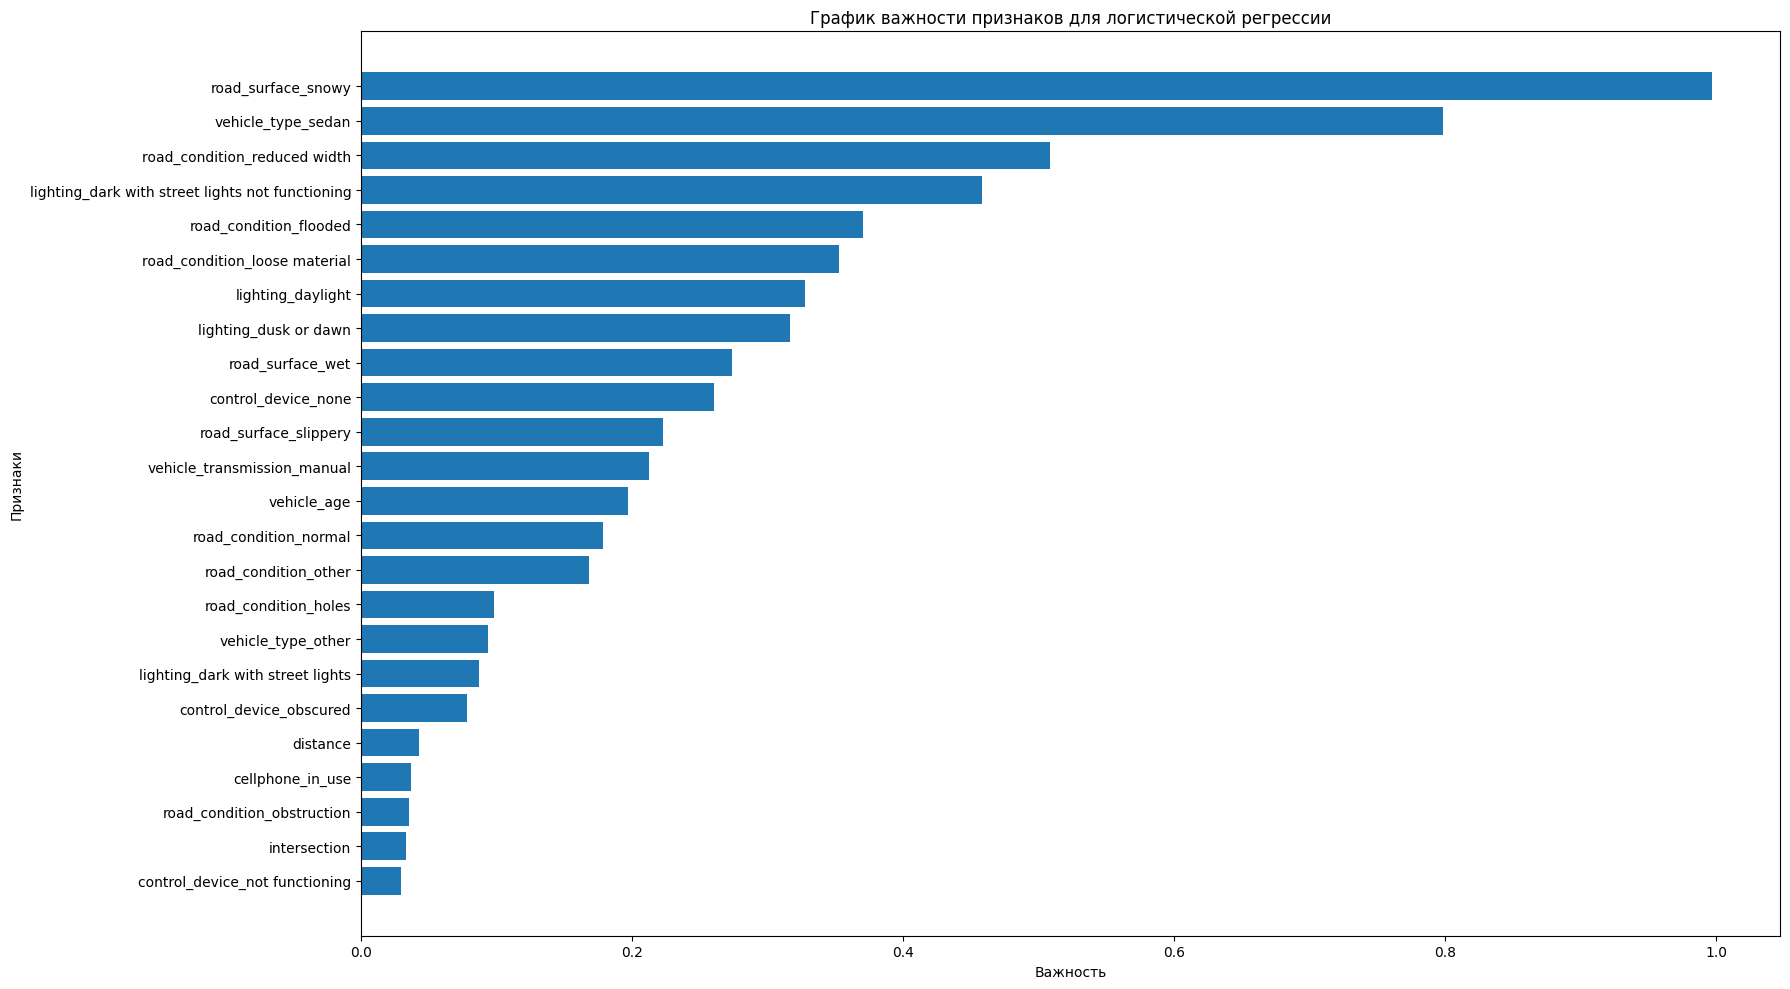

In [131]:
encoded_feature_names = X_train_LR.columns  

importance = np.abs(model.coef_[0])

assert len(encoded_feature_names) == len(importance), \
    f"Количество признаков ({len(encoded_feature_names)}) не совпадает с количеством коэффициентов ({len(importance)})!"

sorted_indices = np.argsort(importance)
sorted_importance = importance[sorted_indices]
sorted_feature_names = [encoded_feature_names[i] for i in sorted_indices]

plt.figure(figsize=(18, 10))
plt.barh(range(len(sorted_importance)), sorted_importance)
plt.yticks(range(len(sorted_importance)), sorted_feature_names)
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('График важности признаков для логистической регрессии')
plt.tight_layout()
plt.show()

Согласно графику можно сказать, что наибольшее влияние на виновность водителя имеют такие признаки как `road_surface`, `road_condition` и `lighting` (состояние дороги, дорожное состояние и освещение). Рассмотрим эти признаки подробней.

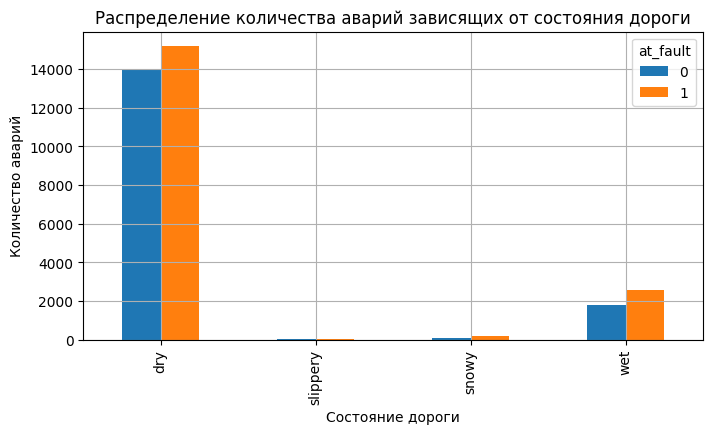

In [132]:
df.pivot_table(
    index='road_surface', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий зависящих от состояния дороги', 
    xlabel='Состояние дороги', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

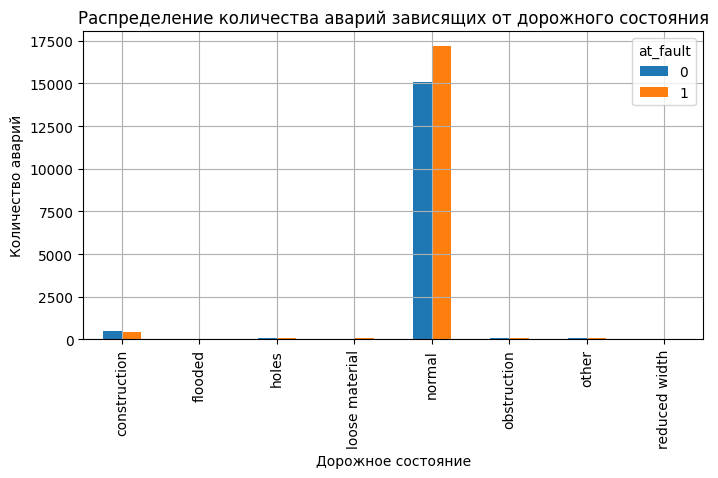

In [133]:
df.pivot_table(
    index='road_condition', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий зависящих от дорожного состояния', 
    xlabel='Дорожное состояние', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

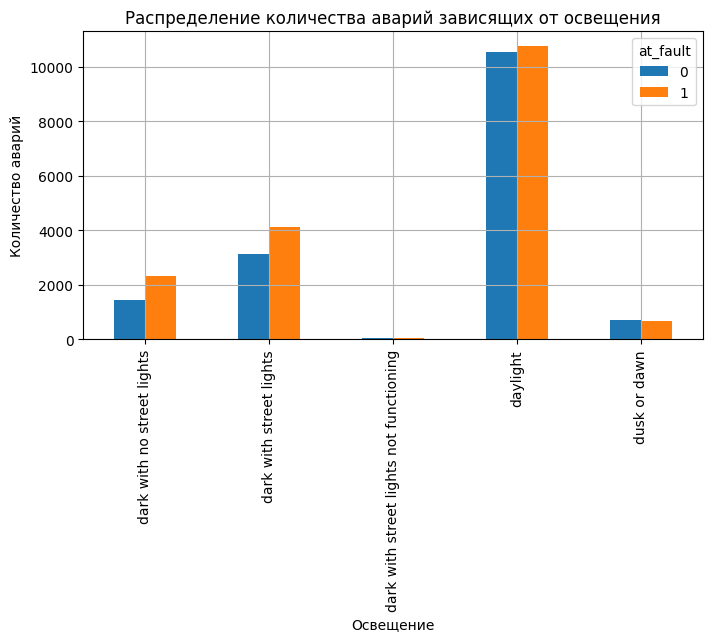

In [134]:
df.pivot_table(
    index='lighting', 
    columns='at_fault', 
    values='vehicle_type', 
    aggfunc='count'
).plot(
    kind='bar',
    title='Распределение количества аварий зависящих от освещения', 
    xlabel='Освещение', 
    figsize=(8, 4), 
    ylabel='Количество аварий',
    grid=True
);

При рассмотрении 3 наиболее важных признаков для модели, можно сделать следующий вывод:\
\
Анализ показывает, что большинство аварий происходит на сухой дороге с хорошим покрытием в дневное время, что указывает на человеческий фактор как основную причину (отвлечение, медленная реакция и т.д.).\
Поэтому я предлогаю установить в автомобили каршеринга систуму ADAS (Advanced Driver Assistance Systems) — это системы помощи водителю, разработанные для повышения безопасности и удобства вождения.\
В состав ADAS входят различные модули, которые работают с помощью сенсоров, камер, радаров и других технологий.

1. **Автономное экстренное торможение (AEB)** — автоматически активирует тормоза при угрозе столкновения.
2. **Адаптивный круиз-контроль (ACC)** — регулирует скорость и дистанцию до впереди идущего автомобиля.
3. **Система удержания полосы (Lane Keeping Assist)** — помогает автомобилю оставаться в пределах полосы.
4. **Мониторинг мертвых зон (Blind Spot Monitoring)** — предупреждает о наличии объектов в мертвых зонах.
5. **Распознавание дорожных знаков** — считывает и выводит на экран важные знаки, такие как ограничения скорости.
6. **Система помощи при парковке** — использует камеры и датчики для безопасной парковки.
7. **Система распознавания пешеходов** — определяет пешеходов на дороге и может тормозить для предотвращения наезда.

## Вывод

В ходе работы над проектом выявили модель, которая показывает наилучшую метрику F1 как на тренировочном наборе данных, так и на тестовом.\
Ей оказалась логистическая регрессия с гиперпараметрами max_iter = 100, penalty = l2.\
Однако нашу модель нельзя назвать хорошей. Модель плохо определяет количество экземпяров класса "виновен", большую часть объектов данного класса модель просто не распознала. Исходя из этого можно сделать вывод, что предсказания такой модели не достаточно хороши, чтобы ее использовать.\
\
С теми данными, которые сейчас имеются создать адекватную систему оценки вероятности ДТП пока не удалось. Я считаю, что для более достойной работы модели необходимо больше данных о водителе.
Например, такие факторы как стаж (не зря в страховых компаниях этот фактор явлется одним из основных), история использования каршеринга, формальный критерий, описывающий безопасность вождения (на сколько средняя скорость водителя отличается от средней скорости потока, можно сделать на основе данных использоания того же каршеринга или навигатора)\
Во время просмотра даных аварии были исключены столбцы которые имели информацию из "будущего", информация об аварии, можно было-бы обучить модель предсказывать эту информацию, а уже на основе ее попробовать предсказать вероятность аварии.\